# Word Frequency analysis

In [91]:
import pandas as pd
import numpy as np
import collections
import operator
import spacy
import nltk
from scipy.spatial.distance import hamming
from nltk.corpus import stopwords
import itertools
from fuzzywuzzy import fuzz
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")

In [92]:
stopwords = stopwords.words('english')

In [93]:
data = pd.read_excel("data/scopus.xls").drop_duplicates().drop(columns=['Unnamed: 0'])

In [94]:
wer_data = pd.read_csv("data/wer_usp.csv")

In [95]:
brainstorm_data = pd.read_excel("data/icb_brainstormed_keywords.xlsx", header=None)

In [96]:
brainstorm_words = [word.lower() for word in brainstorm_data[0].tolist()]

In [97]:
area_data = pd.read_csv("data/area_words.csv")

In [210]:
area_words = area_data.iloc[:, 3].dropna().tolist()
#area_words = list(area_data.fillna(" ").values.flatten())

In [211]:
area_data.head(2)

,Doenças infecciosas,Obesidade e doenças metabólicas,Doenças do envelhecimento,Biotecnologia
0,AIDS,acid-base,ageing,bioengineering
1,anorexia,acidosis,alzheimer,bioinformatics


## Word Frequency

In [212]:
min_wer_data = wer_data.loc[:, ['areaProdutividade', 'nomeDepto', 'programaPos', 'idScopus', 'indicehWoS']].fillna("")

In [213]:
def clean_text(series, area_words):
    clean_series =  (series.str.replace('[^a-zA-Z\s]', '')
                               .str.lower()
                               .where(lambda text: text.str.contains("|".join(area_words)))
                               .str.split(" ", expand=True)
                               .fillna("")
                               .dropna()
                               .values
                               .flatten())
    
    raw_word_list = [word for word in clean_series if word != '']
    clean_word_list = [word for word in raw_word_list if word not in stopwords]
    return clean_word_list

In [214]:
word_list_1 = clean_text(data['authkeywords'], area_words)
word_list_2 = clean_text(data['title'], area_words)

word_list_3 = list(data["description"].str.replace('[^a-zA-Z\s]', '').str.lower().where(lambda text: text.str.contains("|".join(area_words))).dropna().str.split(" ", expand=True).fillna("").values.flatten())
word_bag = word_list_1 + word_list_2 + word_list_3

freq = collections.Counter(word_bag)
word_frequency = sorted(dict(freq).items(), key=operator.itemgetter(1), reverse=True)[1:]
words = [wf[0] for wf in word_frequency][:100]
text = ""
text += "{}\t{}\n".format("count", "word")
for pair in word_frequency:
    text += "{}\t{}\n".format(pair[1], pair[0])
    
with open("all.tsv", "w") as fid:
    fid.write(text)

In [215]:
unique_words = np.unique(word_bag)
len(unique_words)

11613

In [216]:
fuzz_result = {}

for i, brainstorm_word in enumerate(brainstorm_words):
    print("\r{}/{}   ".format(i, len(brainstorm_words)), end='')
    ratios = []
    for word in unique_words:
        ratios.append(fuzz.ratio(brainstorm_word, word))
    fuzz_result[brainstorm_word] = ratios

180/181   

In [217]:
max_value = pd.DataFrame(fuzz_result).max(axis=1)
max_value_column = pd.DataFrame(fuzz_result).idxmax(axis=1)
d = (pd.DataFrame({"max_value": max_value,
                  "max_value_column": max_value_column})
       .assign(original_word=lambda df: unique_words[df.index]))

In [218]:
good_matches = d.where(lambda df: df['max_value'] > 95).dropna()

In [219]:
series = {"word": [word[0] for word in word_frequency],
          "count": [word[1] for word in word_frequency]}

In [220]:
count_df = pd.DataFrame(series)

In [221]:
word_series = count_df.word
for word in brainstorm_words:
    effective_words = (good_matches.where(lambda df: df['max_value_column'] == word)
                                   .dropna()
                                   .original_word
                                   .tolist())
        
    for effective_word in effective_words:
        word_series = word_series.str.replace(effective_word, word)

In [222]:
new_count_df = count_df.copy()
new_count_df.loc[:, 'word'] = word_series

In [223]:
new_count_df.to_csv("data/clean_regex_words_count.csv")

In [224]:
count_dict = {}
for word in brainstorm_words:
    count = new_count_df.where(lambda df: df['word'] == word).dropna().sum()['count']
    count_dict[word] = count

In [225]:
pd.Series(count_dict).sort_values(ascending=False).to_csv("data/brainstorm_words_count.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


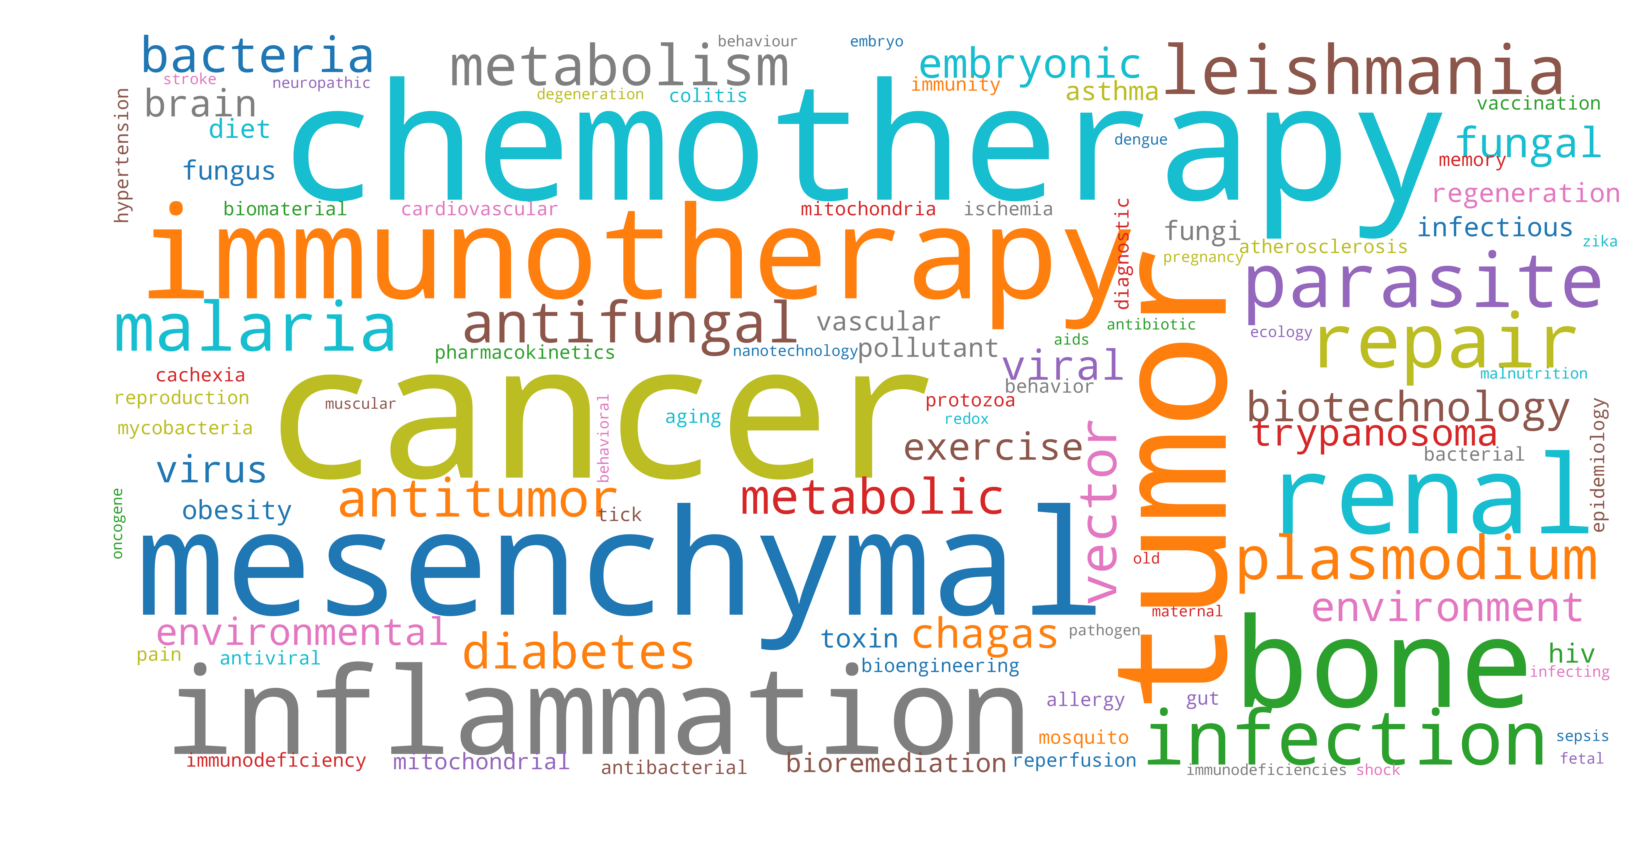

In [226]:
fake_text = ""
for key, value in count_dict.items():
    fake_text += "{} ".format(key) * int(value)
    
    
plt.figure(figsize=(20, 5), dpi=200)
wordcloud = WordCloud(collocations=False, 
                      scale=16,
                      max_font_size=50, 
                      max_words=300, 
                      relative_scaling=0.5,
                      colormap='tab10',
                      background_color="white").generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [227]:
new_count_df.to_csv("data/out_tudo_biotech.csv", index=False)

In [191]:
area_data.T

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
Doenças infecciosas,AIDS,anorexia,antibacterial,antibiotic,antifungal,antiviral,arthropod,bacteria,bacterial,chagas,...,shock,tick,trypanosoma,tuberbulosis,vaccination,vaccine,vector,viral,virus,zika
Obesidade e doenças metabólicas,acid-base,acidosis,alkalosis,breast feeding,cachexia,calorimetry,diabetes,diet,exercise,gluconeogenesis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Doenças do envelhecimento,ageing,alzheimer,anorexia,antitumor,arthritis,atherosclerosis,blood pressure,breathing,cachexia,cancer,...,pain,parkinson,regeneration,repair,reperfusion,stroke,tumor,vascular,NaN,NaN
Biotecnologia,bioengineering,bioinformatics,biological control,biomaterial,bioproduct,bioremediation,biotechnology,chemotherapy,drug delivery,drug development,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
